# Install Dependencies

In [1]:
!pip install torch torchvision tqdm torchmetrics torchinfo numpy pandas matplotlib seaborn watermark

# System and Packages

In [2]:
%load_ext watermark
%reload_ext watermark
%watermark -a 'Pushpakant Behera' -m -v -p torch,torchvision,tqdm,torchmetrics,torchinfo,numpy,pandas,matplotlib,seaborn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Author: Pushpakant Behera

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

torch       : 2.0.0
torchvision : 0.15.1
tqdm        : 4.65.0
torchmetrics: 1.0.0
torchinfo   : 1.8.0
numpy       : 1.23.5
pandas      : 1.5.3
matplotlib  : 3.7.2
seaborn     : 0.12.2

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.120+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



# Imports

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.utils import make_grid

import torchvision
import torchvision.transforms as transforms

import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision,\
                                        MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassConfusionMatrix,\
                                        MulticlassF1Score, MulticlassFBetaScore, MulticlassRecall, MulticlassROC

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

# Configuration

In [4]:
DEVICE_TYPE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(DEVICE_TYPE)

EPOCHS = 32
BATCH_SIZE = 8
# LEARNING_RATE = 3e-4 # karapathy constant
LEARNING_RATE = 1e-2
SCHEDULER_STEP_SIZE = EPOCHS * 0.2
WEIGHT_DECAY = 1e-6
MOMENTUM = 0.9

CHANNELS = 1
WIDTH = 28
HEIGHT = 28
CLASSES = 10

TRAIN_VALID_RATIO = 0.9

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.cuda.empty_cache()

# Preparing Data

In [5]:
train_transform = transforms.Compose([
  transforms.RandomChoice([transforms.RandomRotation(degrees=20),
                           transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                           transforms.RandomAffine(degrees=0, scale=(0.5, 1.25)),
                           transforms.RandomAffine(degrees=0, shear=(-10, 10, -10, 10)),
                           transforms.GaussianBlur(kernel_size=(3,5), sigma=(0.1, 2)),
                           transforms.TrivialAugmentWide(),
  ], p=[0.3, 0.3, 0.2, 0.2, 0.1, 0.1]),
  transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.4),
  transforms.RandomPerspective(distortion_scale=0.05, p=0.2),
  transforms.ToTensor(),
  transforms.Normalize(0.1307, 0.3081)
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.1307, 0.3081)
])

In [6]:
train_valid_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=train_transform)

train_set_size = int(len(train_valid_dataset) * 0.8)
valid_set_size = len(train_valid_dataset) - train_set_size

train_dataset, valid_dataset = random_split(train_valid_dataset, [train_set_size, valid_set_size])
test_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=test_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 352608462.83it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76522864.07it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52307918.14it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11407502.26it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# Visualizing Data

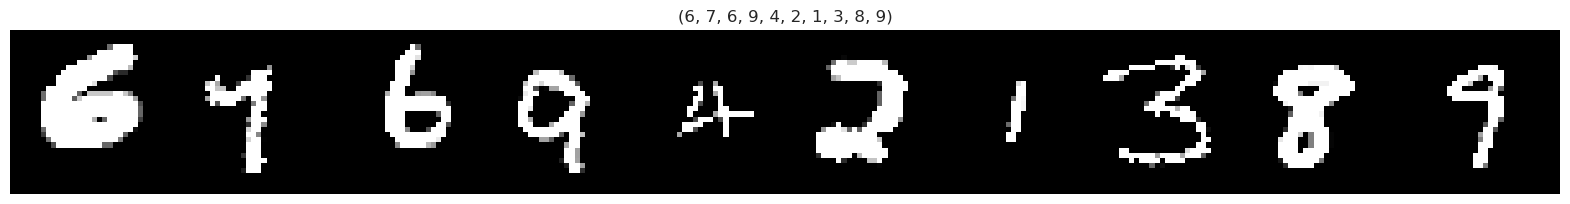

In [8]:
images, labels = zip(*[train_dataset[i] for i in range(10)])

images = torch.stack(images)

fig, ax = plt.subplots(figsize=(20, 10))
grid = make_grid(images, nrow=10, )

plt.title(labels)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

# Model, Loss Function, Optimizer and Scheduler

In [9]:
class MNISTClassifier(nn.Module):
  def __init__(self, channels, classes, dropout_rate):
    super(MNISTClassifier, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=channels,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(num_features=64),
        nn.LeakyReLU(0.1, True),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )
    
    self.conv3 = nn.Sequential(
        nn.Conv2d(
            in_channels=64,
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        ),
        nn.BatchNorm2d(num_features=128),
        nn.LeakyReLU(0.1, True)
    )
    
    # using batchNorm1d is causing error in onnx 🥲
    self.classifier = nn.Sequential(
        nn.Linear(
            in_features=128 * 7 * 7,
            out_features=128 * 3,
#             bias=False
        ),
#         nn.BatchNorm1d(num_features=128 * 3),
        nn.Dropout(dropout_rate),
        nn.LeakyReLU(0.1, True),
        
        nn.Linear(
            in_features=128 * 3, 
            out_features=128, 
#             bias=False
        ),
#         nn.BatchNorm1d(num_features=128),
        nn.Dropout(dropout_rate),
        nn.LeakyReLU(0.1, True),
        
        nn.Linear(in_features=128, out_features=classes),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    
    # x = torch.flatten(x, start_dim=1)
    x = x.view(x.shape[0], -1) # this is inplace, first parameter is batch size
    
    x = self.classifier(x)
    return x

summary(model=MNISTClassifier(channels=CHANNELS, classes=CLASSES, dropout_rate=0.5), input_size=[BATCH_SIZE, 1, WIDTH, HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
MNISTClassifier                          [8, 10]                   --
├─Sequential: 1-1                        [8, 32, 14, 14]           --
│    └─Conv2d: 2-1                       [8, 32, 28, 28]           288
│    └─BatchNorm2d: 2-2                  [8, 32, 28, 28]           64
│    └─ReLU: 2-3                         [8, 32, 28, 28]           --
│    └─MaxPool2d: 2-4                    [8, 32, 14, 14]           --
├─Sequential: 1-2                        [8, 64, 7, 7]             --
│    └─Conv2d: 2-5                       [8, 64, 14, 14]           18,432
│    └─BatchNorm2d: 2-6                  [8, 64, 14, 14]           128
│    └─LeakyReLU: 2-7                    [8, 64, 14, 14]           --
│    └─MaxPool2d: 2-8                    [8, 64, 7, 7]             --
├─Sequential: 1-3                        [8, 128, 7, 7]            --
│    └─Conv2d: 2-9                       [8, 128, 7, 7]            73,728
│    

In [10]:
model = MNISTClassifier(channels=CHANNELS, classes=CLASSES, dropout_rate=0.1).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()

# Metrics Initialization

In [11]:
train_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
]).to(DEVICE)

valid_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
]).to(DEVICE)

test_metrics_coll = MetricCollection([
    MulticlassAccuracy(num_classes=CLASSES, average="micro"),
    MulticlassPrecision(num_classes=CLASSES, average="macro"),
    MulticlassRecall(num_classes=CLASSES, average="macro"),
    MulticlassFBetaScore(num_classes=CLASSES, beta=2.0),
    MulticlassConfusionMatrix(num_classes=CLASSES),
]).to(DEVICE)

train_metrics = []
valid_metrics = []
test_metrics = []

train_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

valid_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

test_metrics_vals = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'fBetaScore': [],
    'loss': []
}

# Training, Validating and Testing function definition

In [12]:
def train(train_loader, model, criterion, optimizer, train_metrics_coll):
  train_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.autocast(device_type=DEVICE_TYPE, dtype=torch.float16):
        outputs = model(images)
        loss = criterion(outputs, labels)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    model.zero_grad() # can use optimizer.zero_grad() as optimizer here is trying to optimize the model parameters 
    
    train_loss += loss.item()
    _, prediction = torch.max(outputs.data, 1)

    batch_metrics = train_metrics_coll.update(outputs, labels)
  
  train_loss /= len(train_loader)
  return train_loss

In [13]:
@torch.inference_mode()
def valid(valid_loader, model, criterion, valid_metrics_coll):
  valid_loss = 0.0
  for i, (images, labels) in enumerate(valid_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)

    valid_loss += loss.item()
    _, prediction = torch.max(outputs.data, 1)

    batch_metrics = valid_metrics_coll.update(outputs, labels)
    
  valid_loss /= len(valid_loader)
  return valid_loss

In [14]:
@torch.inference_mode()
def test(test_loader, model, criterion, test_metrics_coll):
  test_loss = 0.0
  for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)

    test_loss += loss.item()
    _, prediction = torch.max(outputs.data, 1)

    batch_metrics = test_metrics_coll.update(outputs, labels)
    
  test_loss /= len(test_loader)
  return test_loss

# Training and Validation

In [15]:
for epoch in tqdm(range(1, EPOCHS + 1)):
  train_metrics_coll.reset(), valid_metrics_coll.reset()

  model.train()
  train_loss = train(train_loader, model, criterion, optimizer, train_metrics_coll)
  
  scheduler.step()
    
  model.eval()
  valid_loss = valid(valid_loader, model, criterion, valid_metrics_coll)

  tr_met = train_metrics_coll.compute()
  vl_met = valid_metrics_coll.compute()

  train_metrics.append(tr_met)
  valid_metrics.append(vl_met)

  train_metrics_vals['loss'].append(train_loss)
  valid_metrics_vals['loss'].append(valid_loss)

  if not epoch % (EPOCHS * 0.25) or epoch == EPOCHS: # after every 25%
    print(f'Epoch: {epoch}')
    print(f'Train Loss: {train_loss}, Train Accuracy: {tr_met["MulticlassAccuracy"]}')
    print(f'Valid Loss: {valid_loss}, Valid Accuracy: {vl_met["MulticlassAccuracy"]}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8
Train Loss: 0.08178232197711865, Train Accuracy: 0.9741041660308838
Valid Loss: 0.08188991580752099, Valid Accuracy: 0.9739166498184204
Epoch: 16
Train Loss: 0.06039364763846, Train Accuracy: 0.9807083606719971
Valid Loss: 0.07142478346327842, Valid Accuracy: 0.9780833125114441
Epoch: 32
Train Loss: 0.047690591337780155, Train Accuracy: 0.9845208525657654
Valid Loss: 0.06674765071646374, Valid Accuracy: 0.9815000295639038


# Training and Validation Metrics

In [16]:
print(f"Validation Accuracy: {valid_metrics[len(valid_metrics) - 1]['MulticlassAccuracy'].item()}")

Validation Accuracy: 0.9815000295639038


In [17]:
for key, _ in train_metrics_coll.items():
    print(f'{key}: {train_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.9845208525657654
MulticlassPrecision: 0.9845117330551147
MulticlassRecall: 0.9844520688056946
MulticlassFBetaScore: 0.9844624400138855


In [18]:
for key, _ in valid_metrics_coll.items():
    print(f'{key}: {valid_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.9815000295639038
MulticlassPrecision: 0.9816703200340271
MulticlassRecall: 0.9812829494476318
MulticlassFBetaScore: 0.9812864661216736


In [19]:
for metric in train_metrics:
    train_metrics_vals['accuracy'].append(metric['MulticlassAccuracy'].cpu())
    train_metrics_vals['precision'].append(metric['MulticlassPrecision'].cpu())
    train_metrics_vals['recall'].append(metric['MulticlassRecall'].cpu())
    train_metrics_vals['fBetaScore'].append(metric['MulticlassFBetaScore'].cpu())
    
for metric in valid_metrics:
    valid_metrics_vals['accuracy'].append(metric['MulticlassAccuracy'].cpu())
    valid_metrics_vals['precision'].append(metric['MulticlassPrecision'].cpu())
    valid_metrics_vals['recall'].append(metric['MulticlassRecall'].cpu())
    valid_metrics_vals['fBetaScore'].append(metric['MulticlassFBetaScore'].cpu())

# Training and Validation Plots

In [20]:
plt.rcParams["figure.figsize"] = (10, 5)

## Loss

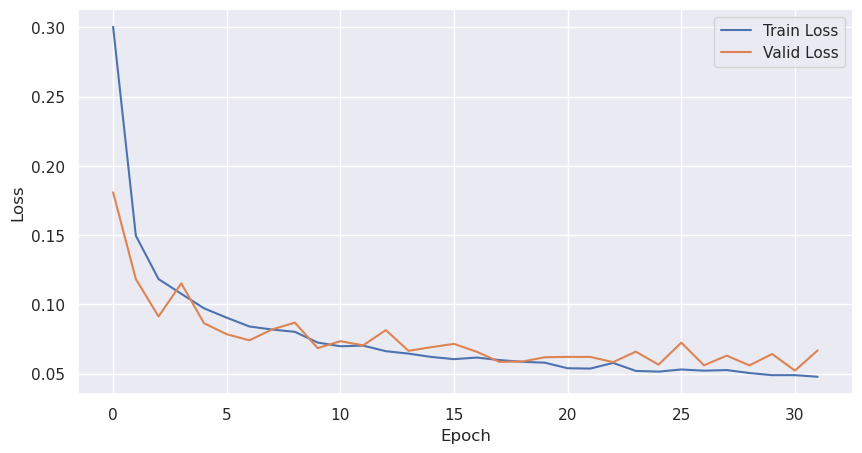

In [21]:
plt.plot(train_metrics_vals['loss'], label="Train Loss")
plt.plot(valid_metrics_vals['loss'], label="Valid Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Accuracy

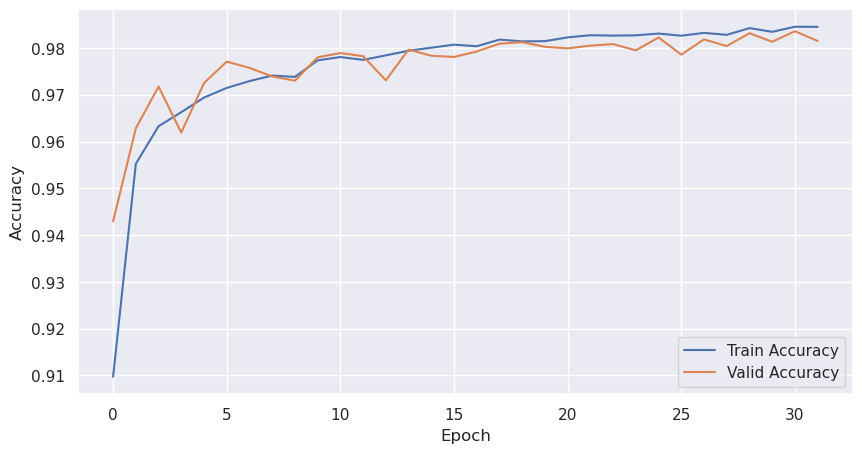

In [22]:
plt.plot(train_metrics_vals['accuracy'], label="Train Accuracy")
plt.plot(valid_metrics_vals['accuracy'], label="Valid Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Precision

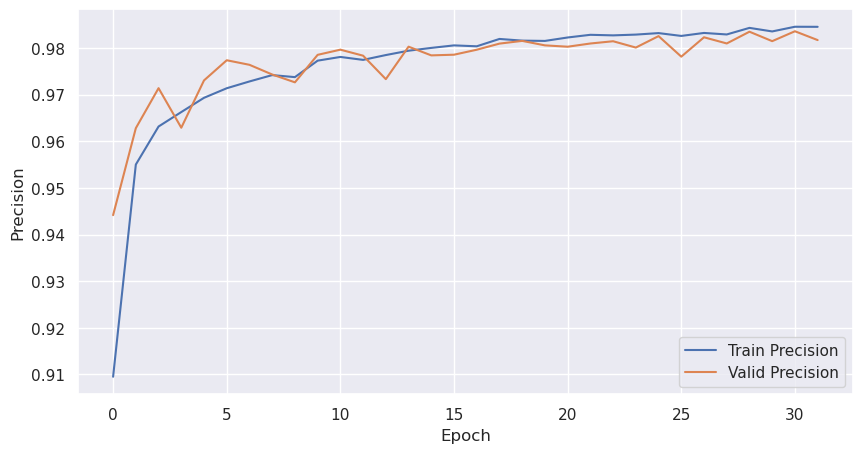

In [23]:
plt.plot(train_metrics_vals['precision'], label="Train Precision")
plt.plot(valid_metrics_vals['precision'], label="Valid Precision")

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Recall

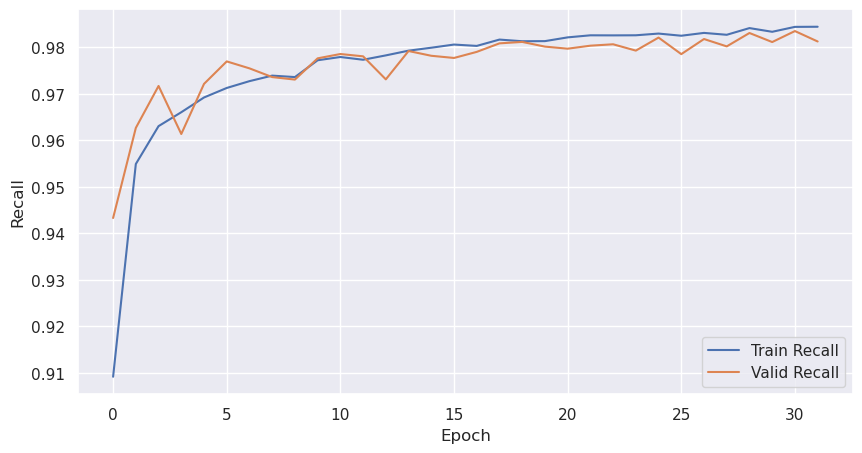

In [24]:
plt.plot(train_metrics_vals['recall'], label="Train Recall")
plt.plot(valid_metrics_vals['recall'], label="Valid Recall")

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

## F-Beta Score

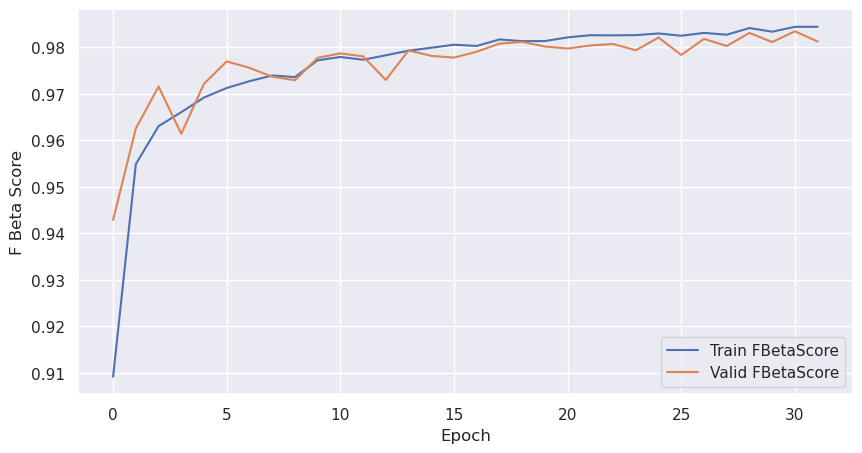

In [25]:
plt.plot(train_metrics_vals['fBetaScore'], label="Train FBetaScore")
plt.plot(valid_metrics_vals['fBetaScore'], label="Valid FBetaScore")

plt.xlabel("Epoch")
plt.ylabel("F Beta Score")
plt.legend()
plt.show()

# Testing

In [26]:
model.eval()
test_loss = test(test_loader, model, criterion, test_metrics_coll)
te_met = test_metrics_coll.compute()
test_metrics.append(te_met)
print(f'Test Loss: {test_loss}')

Test Loss: 0.02075016061103149


# Test Metrics

In [27]:
for key, _ in test_metrics_coll.items():
    print(f'{key}: {test_metrics_coll.compute()[key]}')

MulticlassAccuracy: 0.9939000010490417
MulticlassPrecision: 0.9939595460891724
MulticlassRecall: 0.9938123226165771
MulticlassFBetaScore: 0.9938322305679321
MulticlassConfusionMatrix: tensor([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
        [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4, 1023,    0,    0,    0,    0,    4,    0,    0],
        [   0,    1,    1, 1006,    0,    2,    0,    0,    0,    0],
        [   0,    0,    1,    0,  980,    0,    0,    0,    0,    1],
        [   1,    0,    0,    4,    0,  885,    2,    0,    0,    0],
        [   0,    3,    0,    0,    1,    0,  954,    0,    0,    0],
        [   0,    2,    2,    0,    0,    0,    0, 1024,    0,    0],
        [   4,    0,    3,    1,    1,    1,    1,    0,  961,    2],
        [   0,    0,    0,    0,   12,    3,    0,    1,    0,  993]],
       device='cuda:0')


# Confusion Matrix

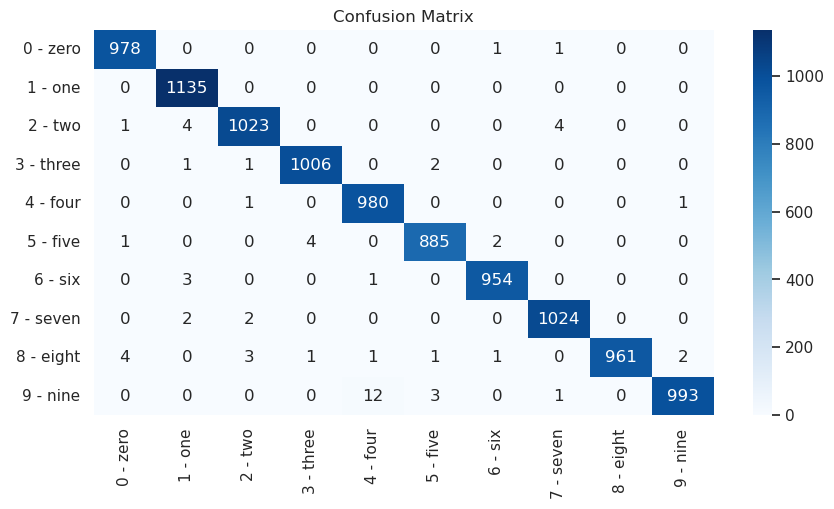

In [28]:
df_cm = pd.DataFrame(test_metrics[len(test_metrics) - 1]['MulticlassConfusionMatrix'].cpu().numpy(), index = train_valid_dataset.classes, columns = train_valid_dataset.classes)
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d').set_title('Confusion Matrix')
plt.yticks(rotation=0)
plt.show()

# Export Model

In [29]:
model.eval()
dummy_input = torch.randn(1, 1, 28, 28, requires_grad=False).to(DEVICE)

torch.onnx.export(model, dummy_input, "model.onnx", export_params=True)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

